In [2]:
:sccache 1
// Skip this or run `cargo install sccache`

sccache: true


In [3]:
:dep z3tracer = { path = "../../z3tracer" }
// TODO: change the path to your local path to z3tracer.

In [4]:
:dep plotters = { default_features = false, features = ["default", "evcxr"] }

In [5]:
:dep petgraph

In [6]:
:dep petgraph-evcxr

In [7]:
:dep multiset

In [8]:
:efmt {:?}

Error format: {:?} (errors must implement std::fmt::Debug)


In [9]:
use z3tracer::{syntax::*, model::*};
use std::collections::*;
use std::str::FromStr;
use plotters::prelude::*;
use plotters::evcxr::SVGWrapper;
use petgraph::graph::Graph;
use multiset::HashMultiSet;

In [ ]:
:last_error_json
// BUG WORKAROUND: In case of mysteriously truncated error 'consider importing this struct', run the command above again
// to print a detailed error and find the import that is actually missing.
//
// See also :help for more useful commands

In [10]:
/// Helper function to process files.
fn process_file(path: &str) -> std::io::Result<Model> {
    let file = std::io::BufReader::new(std::fs::File::open(path)?);
    // Inject non-default configurations here with Model::new(config).
    let mut model = Model::default();
    if let Err(le) = model.process(Some(path.to_string()), file) {
        println!("Error at {:?}: {:?}", le.position, le.error);
    }
    Ok(model)
}

/// Helper trait for models.
trait ModelExt {
    // Pretty-print a term given by its id.
    fn id2s(&self, id: &Ident) -> String;

    // Obtain the name of a term (if any).
    fn id2name(&self, id: &Ident) -> Option<String>;
    
    // Obtain the name of the quantifier behind a QI key.
    fn key2name(&self, k: &QiKey) -> Option<String>;
}

impl ModelExt for Model {
    fn id2s(&self, id: &Ident) -> String {
        self.id_to_sexp(&BTreeMap::new(), id).unwrap()
    }

    fn id2name(&self, id: &Ident) -> Option<String> {
        match self.term(id).ok()? {
            Term::Quant { name, .. } |
            Term::Builtin { name: Some(name) } => Some(name.to_string()),
            _ => None
        }
    }
    
    fn key2name(&self, k: &QiKey) -> Option<String> {
        let qid = self.instantiations().get(k)?.frame.quantifier();
        self.id2name(qid)
    }
}

In [11]:
// TODO: remove after Rust issue 59278 is closed.
struct IntoIterSorted<T> {
    inner: BinaryHeap<T>,
}

impl<T> From<BinaryHeap<T>> for IntoIterSorted<T> {
    fn from(inner: BinaryHeap<T>) -> Self {
        Self { inner }
    }
}

impl<T: Ord> Iterator for IntoIterSorted<T> {
    type Item = T;

    fn next(&mut self) -> Option<T> {
        self.inner.pop()
    }

    fn size_hint(&self) -> (usize, Option<usize>) {
        let exact = self.inner.len();
        (exact, Some(exact))
    }
}

In [12]:
fn plot_instantiations(times: &[(String, Vec<usize>)], title: &str, top_n: usize) -> SVGWrapper {
    let max_ts = times.iter().map(|(_, v)| v.last().cloned().unwrap_or(0)).max().unwrap_or(1);
    let max_count = times[0].1.len();

    evcxr_figure((1000, 800), |root| {
        root.fill(&WHITE);
        let mut chart = ChartBuilder::on(&root)
            .caption(title, ("Arial", 30).into_font())
            .margin(10)
            .x_label_area_size(40)
            .y_label_area_size(50)
            .build_cartesian_2d(0..max_ts, 0..max_count)?;

        chart.configure_mesh().y_desc("Cumulative number of instantiations").x_desc("Time (line number)").draw()?;

        for (j, (name, values)) in times.iter().take(top_n).enumerate() {
            let color : PaletteColor<Palette9999> = PaletteColor::pick(j);
            chart
            .draw_series(
                LineSeries::new(values.iter().enumerate().map(|(i, c)| (*c, i)), &color)
            ).unwrap()
            .label(name)
            .legend(move |(x, y)| PathElement::new(vec![(x, y), (x + 20, y)], color.filled()));
        }

        chart.configure_series_labels()
            .background_style(&WHITE.mix(0.8))
            .border_style(&BLACK)
            .position(SeriesLabelPosition::UpperLeft)
            .draw()?;
        Ok(())
    })
}

In [13]:
fn plot_scopes(scopes: &[(/* ts */ usize, /* level */ u64)], title: &str) -> SVGWrapper {
    let max_ts = scopes.iter().map(|(ts, _)| *ts).max().unwrap_or(1);
    let max_level = scopes.iter().map(|(_, l)| *l).max().unwrap_or(1);

    evcxr_figure((1000, 800), |root| {
        root.fill(&WHITE);
        let mut chart = ChartBuilder::on(&root)
            .caption(title, ("Arial", 30).into_font())
            .margin(10)
            .x_label_area_size(40)
            .y_label_area_size(50)
            .build_cartesian_2d(0..max_ts, (0..max_level).log_scale())?;

        chart.configure_mesh().y_desc("Backtracking level").x_desc("Time (line number)").draw()?;

        let data = scopes.iter().scan(None, |state, (ts, l)| {
            let prev = *state;
            *state = Some((*ts, *l));
            let r = match prev {
                Some((p, l)) => vec![(p, l), (*ts - 1, l)],
                None => Vec::new()
            };
            Some(r)
        }).flatten();
        
        let color = BLUE;
        chart
        .draw_series(LineSeries::new(data, &color)).unwrap()
        .label("Backtracking level")
        .legend(move |(x, y)| PathElement::new(vec![(x, y), (x + 20, y)], color.filled()));

        chart.configure_series_labels()
            .background_style(&WHITE.mix(0.8))
            .border_style(&BLACK)
            .position(SeriesLabelPosition::UpperLeft)
            .draw()?;
        Ok(())
    })
}

In [14]:
fn plot_instantiations_with_scopes(times: &[(String, Vec<usize>)], title: &str, top_n: usize, scopes: &[(/* ts */ usize, /* level */ u64)]) -> SVGWrapper {
    let max_ts = times.iter().map(|(_, v)| v.last().cloned().unwrap_or(0)).chain(scopes.iter().map(|(ts, _)| *ts)).max().unwrap_or(1);
    let max_count = times[0].1.len();
    let max_level = scopes.iter().map(|(_, l)| *l).max().unwrap_or(1);

    evcxr_figure((1000, 800), |root| {
        root.fill(&WHITE);
        let mut chart = ChartBuilder::on(&root)
            .caption(title, ("Arial", 30).into_font())
            .margin(10)
            .x_label_area_size(40)
            .y_label_area_size(50)
            .right_y_label_area_size(40)
            .build_cartesian_2d(0..max_ts, 0..max_count)?
            .set_secondary_coord(0..max_ts, (0..max_level).log_scale());

        chart.configure_mesh().y_desc("Cumulative number of instantiations").x_desc("Time (line number)").draw()?;
        chart
            .configure_secondary_axes()
            .y_desc("Backtracking level")
            .draw()?;
        
        for (j, (name, values)) in times.iter().take(top_n).enumerate() {
            let color : PaletteColor<Palette9999> = PaletteColor::pick(j);
            chart
            .draw_series(
                LineSeries::new(values.iter().enumerate().map(|(i, c)| (*c, i)), &color)
            ).unwrap()
            .label(name)
            .legend(move |(x, y)| PathElement::new(vec![(x, y), (x + 20, y)], color.filled()));
        }
        
        let data = scopes.iter().scan(None, |state, (ts, l)| {
            let prev = *state;
            *state = Some((*ts, *l));
            let r = match prev {
                Some((p, l)) => vec![(p, l), (*ts - 1, l)],
                None => Vec::new()
            };
            Some(r)
        }).flatten();
        
        let color = BLUE;
        chart
        .draw_secondary_series(LineSeries::new(data, &color)).unwrap()
        .label("Backtracking level")
        .legend(move |(x, y)| PathElement::new(vec![(x, y), (x + 20, y)], color.filled()));

        chart.configure_series_labels()
            .background_style(&WHITE.mix(0.8))
            .border_style(&BLACK)
            .position(SeriesLabelPosition::UpperLeft)
            .draw()?;
        Ok(())
    })
}

In [15]:
fn plot_instantiations_with_conflicts(times: &[(String, Vec<usize>)], title: &str, top_n: usize, conflict_qis: &[(/* ts */ usize, /* names */ BTreeSet<String>)]) -> SVGWrapper {
    let max_ts = times.iter().map(|(_, v)| v.last().cloned().unwrap_or(0)).max().unwrap_or(1);
    let max_count = times[0].1.len();

    evcxr_figure((1000, 800), |root| {
        root.fill(&WHITE);
        let mut chart = ChartBuilder::on(&root)
            .caption(title, ("Arial", 30).into_font())
            .margin(10)
            .x_label_area_size(40)
            .y_label_area_size(50)
            .build_cartesian_2d(0..max_ts, 0..max_count)?;

        chart.configure_mesh().y_desc("Cumulative number of instantiations").x_desc("Time (line number)").draw()?;
        
        for (j, (name, values)) in times.iter().take(top_n).enumerate() {
            let conflict_ts = conflict_qis.iter().filter_map(|(ts, names)| if names.contains(name) { Some(*ts) } else { None }).collect::<Vec<_>>();
            let conflicts = conflict_ts.into_iter().map(|ts| (ts, values.binary_search(&ts).map_or_else(|x| x, |x| x))).collect::<Vec<_>>();
            
            let color : PaletteColor<Palette9999> = PaletteColor::pick(j);
            chart
            .draw_series(
                LineSeries::new(values.iter().enumerate().map(|(i, c)| (*c, i)), &color)
            ).unwrap()
            .label(name)
            .legend(move |(x, y)| PathElement::new(vec![(x, y), (x + 20, y)], color.filled()));

            let color : PaletteColor<Palette9999> = PaletteColor::pick(j);
            chart
            .draw_series(
                PointSeries::<_, _, Circle<_, _>, _>::new(conflicts, 4, Into::<ShapeStyle>::into(&color).filled())
            ).unwrap();
        }
        
        chart.configure_series_labels()
            .background_style(&WHITE.mix(0.8))
            .border_style(&BLACK)
            .position(SeriesLabelPosition::UpperLeft)
            .draw()?;
        Ok(())
    })
}

In [16]:
// Process some input file obtained with `z3 trace=true proof=true ..`
let model = process_file("../tests/data/file1.log")?;

In [17]:
// Maximum timestamp (i.e. currently, the number of lines in the Z3 log)
let max_ts = model.processed_logs();
max_ts

443166

In [18]:
// Compute top instantiated terms.
let mut top = model.most_instantiated_terms();
top.len()

66

In [19]:
// Peek at the 20th top elements
IntoIterSorted::from(top.clone()).take(20).collect::<Vec<_>>()

[(7903, basic#), (2955, datatype#85), (2955, datatype#82), (1863, datatype#), (1114, arith#), (769, datatype#59), (331, #4429!9), (304, #4328), (232, datatype#47), (224, #20151!10), (126, #20468!5), (120, #4351!1), (119, #23065!1), (119, #4347!1), (115, #4337), (100, #23092!1), (99, #23078!2), (97, datatype#53), (93, datatype#143), (93, datatype#140)]

In [20]:
// Compute top instantiated terms and retrieve the "timestamps" at which instantiations occur for each of the top terms.
let instantiation_times = IntoIterSorted::from(model.most_instantiated_terms()).map(|(_count, id)| {
    let mut timestamps = model.term_data(&id).unwrap().instantiation_timestamps.clone();
    timestamps.sort();
    let name = model.id2name(&id).unwrap_or_else(|| "??".to_string());
    (name.to_string(), timestamps)
}).collect::<Vec<_>>();

In [21]:
plot_instantiations(&instantiation_times, "Top 10 Quantifiers Instantiations", 10)

Top 10 Quantifiers Instantiations
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
Cumulative number of instantiations
 
 
Time (line number)
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
0
 
 
 
1000
 
 
 
2000
 
 
 
3000
 
 
 
4000
 
 
 
5000
 
 
 
6000
 
 
 
7000
 
 
 
 
0
 
 
 
50000
 
 
 
100000
 
 
 
150000
 
 
 
200000
 
 
 
250000
 
 
 
300000
 
 
 
350000
 
 
 
400000
 
 
<polyline fill="none" opacity="1" stroke="#FFE119" stroke-width="1" points="60,749 60,748 60,748 60,748 60,748 61,748 61,748 61,748 61,748 61,748 61,748 61,748 61,747 61,747 62,747 62,747 62,747 62,747 62,747 62,747 64,747 64,747 64,747 64,746 64,746 64,746 64,746 64,746 64,746 64,746 65,746 65,746 65,746 65,746 65,745 65,745 65,745 65,745 65,745 65,745 65,745 65,745 65,745 65,745 65,745 65,744 65,744 67,744 67,744 68,744 68,744 68,744 68,744 68,744 68,744 68,744 70,744 70,743 70,743 70,743 81,743 82,743 82,743 82,743 82,743 82,743 85,743 85,743 86,742 86,742 86,742 86,742 86,742 86,742 86,742 86,742 86,742 86,742 86,742 86,741 86,741 86,741 86,741 86,741 86,741 86,741 86,741 86,741 86,741 86,741 86,740 86,740 86,740 86,740 86,740 86,740 86,740 86,740 86,740 86,740 86,740 86,740 86,739 86,739 87,739 87,739 87,739 87,739 87,739 87,739 87,739 87,739 87,739 87,738 87,738 87,738 87,738 87,738 87,738 87,738 87,738 87,738 87,738 87,738 88,737 88,737 88,737 88,737 88,737 88,737 88,737 88,737 88,737 88,737 88,737 89,736 89,736 89,736 89,736 89,736 94,736 94,736 94,736 94,736 94,736 94,736 95,735 95,735 95,735 95,735 95,735 95,735 95,735 95,735 95,735 95,735 95,735 95,735 95,734 95,734 95,734 95,734 95,734 95,734 95,734 95,734 95,734 95,734 95,734 95,733 95,733 95,733 95,733 95,733 95,733 96,733 96,733 96,733 96,733 96,733 96,732 96,732 97,732 97,732 97,732 97,732 97,732 97,732 97,732 97,732 97,732 97,731 97,731 97,731 97,731 97,731 97,731 97,731 97,731 97,731 97,731 97,731 97,731 97,730 97,730 97,730 97,730 97,730 97,730 97,730 97,730 97,730 97,730 97,730 98,729 98,729 98,729 98,729 98,729 98,729 98,729 142,729 142,729 142,729 142,729 142,728 142,728 142,728 142,728 142,728 142,728 142,728 142,728 142,728 143,728 143,728 143,727 143,727 144,727 144,727 144,727 144,727 144,727 144,727 144,727 144,727 144,727 144,726 144,726 144,726 144,726 144,726 145,726 145,726 145,726 145,726 145,726 145,726 145,726 145,725 145,725 145,725 145,725 145,725 146,725 146,725 146,725 146,725 146,725 146,725 146,724 146,724 146,724 146,724 146,724 146,724 146,724 147,724 147,724 147,724 147,724 147,723 147,723 147,723 147,723 147,723 147,723 147,723 147,723 147,723 147,723 147,723 148,722 148,722 148,722 148,722 148,722 148,722 148,722 148,722 148,722 148,722 148,722 148,722 148,721 148,721 148,721 149,721 149,721 149,721 149,721 149,721 149,721 149,721 149,721 150,720 150,720 150,720 150,720 150,720 150,720 150,720 150,720 150,720 150,720 150,720 150,719 150,719 150,719 151,719 151,719 151,719 151,719 151,719 151,719 151,719 151,719 151,718 151,718 151,718 151,718 151,718 151,718 151,718 151,718 151,718 152,718 152,718 152,718 152,717 152,717 152,717 152,717 152,717 152,717 152,717 152,717 152,717 152,717 152,717 152,716 152,716 152,716 152,716 152,716 152,716 152,716 152,716 152,716 153,716 153,716 153,715 153,715 153,715 153,715 153,715 153,715 153,715 153,715 154,715 154,715 154,715 154,714 154,714 154,714 154,714 154,714 154,714 154,714 154,714 155,714 155,714 155,714 155,713 155,713 155,713 155,713 155,713 155,713 155,713 155,713 156,713 156,713 156,713 156,713 156,712 156,712 156,712 156,712 156,712 157,712 157,712 157,712 157,712 157,712 157,712 157,711 157,711 157,711 157,711 157,711 157,711 157,711 157,711 157,711 158,711 158,711 158,710 158,710 158,710 158,710 158,710 158,710 158,710 15

In [22]:
// Top instantiated quantified term.
model.id2s(&top.peek()?.1)

"basic"

In [23]:
// Final counter and `Ident` value for the top term.
top.peek()?

(7903, basic#)

In [24]:
// Move to the first user quantifier
while !model.term(&top.peek()?.1)?.name().unwrap_or("").starts_with("outputbpl") { top.pop(); }
top.peek()?

(331, #4429!9)

In [25]:
// Introspect a particular term, given by handle.
// Note that the version number `!9` was added during parsing for disambiguation and is not present in the original log file.
model.term(&Ident::from_str("#4429!9")?)?

Quant { name: "outputbpl.310:31", params: 2, triggers: [#284], body: #4443, var_names: Some([VarName { name: Symbol("v2"), sort: Symbol("T@$Value") }, VarName { name: Symbol("v1"), sort: Symbol("T@$Value") }]) }

In [26]:
model.term_data(&Ident::from_str("#4429!9")?)?.instantiations.len()

359

In [27]:
// Create a new chart only with quantifier instantiation inside the file `outputbpl`.
let user_instantiation_times = instantiation_times.clone().into_iter().filter(|(n, _)| n.starts_with("outputbpl")).collect::<Vec<_>>();

plot_instantiations(&user_instantiation_times, "Top 10 User Quantifiers Instantiations", 10)

Top 10 User Quantifiers Instantiations
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
Cumulative number of instantiations
 
 
Time (line number)
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
0
 
 
 
50
 
 
 
100
 
 
 
150
 
 
 
200
 
 
 
250
 
 
 
300
 
 
 
 
0
 
 
 
50000
 
 
 
100000
 
 
 
150000
 
 
 
200000
 
 
 
250000
 
 
 
300000
 
 
 
350000
 
 
 
400000
 
 
<polyline fill="none" opacity="1" stroke="#FFE119" stroke-width="1" points="255,749 256,746 257,744 291,742 292,740 293,738 296,736 296,734 297,731 301,729 302,727 305,725 307,723 308,721 308,719 309,717 341,714 341,712 342,710 346,708 347,706 347,704 348,702 351,700 352,697 386,695 386,693 387,691 391,689 394,687 394,685 394,683 395,680 396,678 398,676 398,674 398,672 399,670 400,668 400,666 401,663 402,661 403,659 403,657 404,655 404,653 405,651 405,649 406,646 406,644 448,642 448,640 448,638 449,636 449,634 450,632 450,629 451,627 452,625 452,623 452,621 453,619 454,617 454,615 455,612 455,610 455,608 456,606 456,604 457,602 457,600 457,597 458,595 460,593 460,591 461,589 461,587 462,585 462,583 480,580 481,578 481,576 482,574 482,572 483,570 483,568 490,566 490,563 491,561 511,559 512,557 513,555 514,553 516,551 517,549 533,546 534,544 535,542 536,540 536,538 547,536 548,534 551,532 551,529 554,527 554,525 556,523 557,521 557,519 569,517 573,515 574,512 574,510 584,508 584,506 585,504 585,502 586,500 586,498 586,495 587,493 587,491 588,489 594,487 594,485 612,483 613,481 613,478 615,476 617,474 617,472 618,470 619,468 620,466 620,463 624,461 626,459 626,457 627,455 632,453 632,451 633,449 633,446 635,444 635,442 638,440 639,438 652,436 653,434 655,432 655,429 655,427 656,425 656,423 656,421 657,419 658,417 658,415 659,412 659,410 659,408 660,406 660,404 660,402 660,400 661,398 661,395 661,393 664,391 664,389 665,387 665,385 666,383 666,381 666,378 667,376 667,374 667,372 668,370 668,368 669,366 669,364 686,361 687,359 687,357 688,355 688,353 688,351 689,349 689,347 689,344 689,342 694,340 694,338 694,336 695,334 695,332 695,330 712,327 713,325 714,323 715,321 715,319 716,317 716,315 719,312 723,310 723,308 724,306 724,304 724,302 725,300 725,298 726,295 726,293 727,291 728,289 728,287 728,285 729,283 729,281 730,278 730,276 730,274 740,272 741,270 741,268 741,266 742,264 744,261 744,259 744,257 744,255 745,253 745,251 760,249 760,247 760,244 761,242 762,240 762,238 762,236 763,234 763,232 763,230 772,227 773,225 779,223 779,221 779,219 779,217 780,215 780,213 789,210 789,208 795,206 795,204 796,202 796,200 796,198 797,196 797,193 798,191 800,189 800,187 801,185 801,183 801,181 802,178 802,176 819,174 820,172 820,170 820,168 822,166 822,164 842,161 842,159 843,157 847,155 847,153 849,151 849,149 850,147 850,144 850,142 851,140 871,138 871,136 872,134 872,132 872,130 873,127 873,125 894,123 898,121 902,119 902,117 903,115 903,113 903,110 921,108 921,106 922,104 922,102 923,100 924,98 925,96 926,93 942,91 950,89 951,87 951,85 951,83 952,81 952,79 965,76 966,74 967,72 969,70 969,68 970,66 970,64 971,62 971,59 971,57 971,55 972,53 972,51 984,49 984,47 "/>
<polyline fill="none" opacity="1" stroke="#0082C8" stroke-width="1" points="255,749 256,746 256,744 290,742 291,740 292,738 295,736 296,734 297,731 301,729 305,727 307,725 307,723 308,721 309,719 340,717 341,714 341,712 346,710 346,708 347,706 347,704 350,702 351,700 352,697 385,695 386,693 387,691 389,689 391,687 393,685 394,683 394,680 394,678 395,676 397,674 398,672 398,670 398,668 399,666 400,663 400,661 400,659 401,657 402,655 403,653 403,651 404,649 404,646 404,644 406,642 447,640 448,638 448,636 449,634 450,632 450,629 451,627 451,625 452,623 452,621 452,619 453,617 454,615 455,612 455,610 455,608 456,606 457,604 457,602 457,600 459,597 460,595 460,593

In [28]:
// A "scope" is a period of computation at the same backtracking level.
let scopes = model.scopes().iter().map(|s| (s.timestamp, s.level)).collect::<Vec<(usize, u64)>>();

In [29]:
plot_scopes(&scopes, "Backtracking levels")

Backtracking levels
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
Backtracking level
 
 
Time (line number)
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
1
 
 
 
10
 
 
 
100
 
 
 
 
0
 
 
 
50000
 
 
 
100000
 
 
 
150000
 
 
 
200000
 
 
 
250000
 
 
 
300000
 
 
 
350000
 
 
 
400000
 
 
<polyline fill="none" opacity="1" stroke="#0000FF" stroke-width="1" points="60,749 135,749 135,674 290,674 290,599 290,599 290,555 291,555 291,524 293,524 293,500 306,500 306,481 340,481 340,464 350,464 350,450 350,450 350,437 383,437 383,426 383,426 383,415 385,415 385,406 385,406 385,397 385,397 385,389 385,389 385,382 385,382 385,375 385,375 385,369 385,369 385,362 385,362 385,357 385,357 385,351 385,351 385,346 385,346 385,341 385,341 385,336 385,336 385,331 385,331 385,327 385,327 385,323 385,323 385,319 385,319 385,315 385,315 385,311 385,311 385,307 385,307 385,304 385,304 385,300 385,300 385,297 385,297 385,294 385,294 385,291 385,291 385,288 385,288 385,285 385,285 385,282 385,282 385,279 385,279 385,276 385,276 385,274 385,274 385,271 385,271 385,269 385,269 385,266 385,266 385,264 385,264 385,261 385,261 385,259 385,259 385,257 385,257 385,254 385,254 385,252 385,252 385,250 385,250 385,248 385,248 385,246 385,246 385,244 385,244 385,242 385,242 385,240 385,240 385,238 385,238 385,236 385,236 385,234 385,234 385,233 385,233 385,231 385,231 385,229 385,229 385,227 385,227 385,226 385,226 385,224 385,224 385,222 385,222 385,221 385,221 385,219 385,219 385,218 385,218 385,216 385,216 385,215 385,215 385,213 385,213 385,212 385,212 385,210 385,210 385,209 385,209 385,207 385,207 385,206 385,206 385,204 385,204 385,203 385,203 385,202 385,202 385,200 385,200 385,199 385,199 385,198 385,198 385,196 385,196 385,195 385,195 385,194 385,194 385,193 385,193 385,191 385,191 385,190 385,190 385,189 385,189 385,188 385,188 385,187 385,187 385,185 385,185 385,184 385,184 385,183 388,183 388,182 388,182 388,181 389,181 389,180 390,180 390,179 392,179 392,382 393,382 393,375 393,375 393,369 393,369 393,362 393,362 393,357 393,357 393,351 393,351 393,346 393,346 393,341 393,341 393,336 393,336 393,331 393,331 393,327 393,327 393,323 393,323 393,319 393,319 393,315 393,315 393,311 393,311 393,307 393,307 393,304 393,304 393,300 393,300 393,297 393,297 393,294 393,294 393,291 393,291 393,288 393,288 393,285 393,285 393,282 393,282 393,279 393,279 393,276 393,276 393,274 393,274 393,271 393,271 393,269 393,269 393,266 393,266 393,264 393,264 393,261 393,261 393,259 393,259 393,257 393,257 393,254 393,254 393,252 395,252 395,250 395,250 395,248 395,248 395,246 395,246 395,244 395,244 395,242 395,242 395,240 395,240 395,238 395,238 395,236 395,236 395,234 395,234 395,233 395,233 395,231 395,231 395,229 395,229 395,227 395,227 395,226 395,226 395,224 395,224 395,222 395,222 395,221 395,221 395,219 395,219 395,218 395,218 395,216 397,216 397,382 397,382 397,375 397,375 397,369 399,369 399,362 399,362 399,357 399,357 399,351 399,351 399,346 399,346 399,341 399,341 399,336 399,336 399,331 399,331 399,327 399,327 399,323 399,323 399,319 399,319 399,315 399,315 399,311 399,311 399,307 399,307 399,304 399,304 399,300 399,300 399,297 399,297 399,294 399,294 399,291 399,291 399,288 399,288 399,285 399,285 399,282 399,282 399,279 399,279 399,276 399,276 399,274 399,274 399,271 399,271 399,269 399,269 399,266 399,266 399,264 399,264 399,261 399,261 399,259 399,259 399,257 399,257 399,254 399,254 399,252 399,252 399,250 399,250 399,248 399,248 399,246 399,246 399,244 399,244 399,242 399,242 399,382 400,382 400,375 401,375 401,369 401,369 401,362 401,362 401,357 401,357 401,351 401,351 401,346 401,346 401,341 401,341 401,336 401,336 401,331 401,331 401,327 401,327 401,323 401,323 401,319 401,319 401,315 401,315 401,311 401,311 401,307 401,307 401,304 401,304 401,300 401,300 401,297 401,297 401,294 401

In [30]:
plot_instantiations_with_scopes(&instantiation_times, "Top 10 Quantifiers Instantiations + backtracking levels", 10, &scopes)

Top 10 Quantifiers Instantiations + backtracking levels
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
Cumulative number of instantiations
 
 
Time (line number)
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
0
 
 
 
1000
 
 
 
2000
 
 
 
3000
 
 
 
4000
 
 
 
5000
 
 
 
6000
 
 
 
7000
 
 
 
 
0
 
 
 
50000
 
 
 
100000
 
 
 
150000
 
 
 
200000
 
 
 
250000
 
 
 
300000
 
 
 
350000
 
 
 
400000
 
 
 
Backtracking level
 
 
 
1
 
 
 
10
 
 
 
100
 
 
<polyline fill="none" opacity="1" stroke="#FFE119" stroke-width="1" points="60,749 60,748 60,748 60,748 60,748 61,748 61,748 61,748 61,748 61,748 61,748 61,748 61,747 61,747 62,747 62,747 62,747 62,747 62,747 62,747 64,747 64,747 64,747 64,746 64,746 64,746 64,746 64,746 64,746 64,746 64,746 64,746 64,746 64,746 64,745 64,745 65,745 65,745 65,745 65,745 65,745 65,745 65,745 65,745 65,745 65,744 65,744 67,744 67,744 67,744 67,744 67,744 68,744 68,744 68,744 68,744 70,744 70,743 70,743 70,743 80,743 81,743 81,743 81,743 81,743 81,743 84,743 84,743 84,742 84,742 84,742 84,742 84,742 85,742 85,742 85,742 85,742 85,742 85,742 85,741 85,741 85,741 85,741 85,741 85,741 85,741 85,741 85,741 85,741 85,741 85,740 85,740 85,740 85,740 85,740 85,740 85,740 85,740 85,740 85,740 85,740 85,740 85,739 85,739 85,739 85,739 85,739 86,739 86,739 86,739 86,739 86,739 86,739 86,738 86,738 86,738 86,738 86,738 86,738 86,738 86,738 86,738 86,738 86,738 87,737 87,737 87,737 87,737 87,737 87,737 87,737 87,737 87,737 87,737 87,737 87,736 87,736 87,736 87,736 88,736 93,736 93,736 93,736 93,736 93,736 93,736 93,735 93,735 93,735 93,735 93,735 93,735 93,735 93,735 93,735 93,735 93,735 93,735 93,734 93,734 93,734 93,734 93,734 93,734 93,734 93,734 93,734 93,734 94,734 94,733 94,733 94,733 94,733 94,733 94,733 94,733 94,733 94,733 94,733 94,733 94,732 94,732 95,732 95,732 95,732 95,732 95,732 95,732 95,732 95,732 95,732 95,731 95,731 95,731 95,731 95,731 95,731 95,731 95,731 95,731 95,731 95,731 95,731 95,730 95,730 95,730 95,730 96,730 96,730 96,730 96,730 96,730 96,730 96,730 96,729 96,729 96,729 96,729 96,729 96,729 96,729 138,729 138,729 138,729 138,729 138,728 138,728 138,728 139,728 139,728 139,728 139,728 139,728 139,728 139,728 139,728 139,727 140,727 140,727 140,727 140,727 140,727 140,727 140,727 140,727 140,727 140,727 141,726 141,726 141,726 141,726 141,726 141,726 141,726 141,726 141,726 141,726 141,726 141,726 141,725 141,725 141,725 142,725 142,725 142,725 142,725 142,725 142,725 142,725 142,725 142,724 142,724 142,724 142,724 142,724 142,724 143,724 143,724 143,724 143,724 143,724 143,723 143,723 143,723 143,723 143,723 143,723 143,723 143,723 143,723 144,723 144,723 144,722 144,722 144,722 144,722 144,722 144,722 144,722 144,722 144,722 144,722 144,722 144,722 145,721 145,721 145,721 145,721 145,721 145,721 145,721 145,721 145,721 146,721 146,721 146,720 146,720 146,720 146,720 146,720 146,720 146,720 146,720 146,720 146,720 146,720 146,719 146,719 147,719 147,719 147,719 147,719 147,719 147,719 147,719 147,719 147,719 147,718 147,718 147,718 147,718 147,718 147,718 147,718 147,718 147,718 148,718 148,718 148,718 148,717 148,717 148,717 148,717 148,717 148,717 148,717 148,717 148,717 148,717 148,717 148,716 148,716 148,716 148,716 148,716 148,716 148,716 148,716 148,716 148,716 149,716 149,715 149,715 149,715 149,715 149,715 149,715 149,715 149,715 149,715 150,715 150,715 150,714 150,714 150,714 150,714 150,714 150,714 150,714 150,714 151,714 151,714 151,714 151,713 151,713 151,713 151,713 151,713 151,713 151,713 151,713 151,713 151,713 151,713 151,713 152,712 152,712 152,712 152,712 152,712 152,712 152,712 153,712 153,712 153,712 153,712 153,711 153,711 153,711 153,711 153,711 153,711 153,711 153,711 153,711 

In [31]:
plot_instantiations_with_scopes(&user_instantiation_times, "Top 10 User Quantifiers Instantiations + backtracking levels", 10, &scopes)

Top 10 User Quantifiers Instantiations + backtracking levels
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
Cumulative number of instantiations
 
 
Time (line number)
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
0
 
 
 
50
 
 
 
100
 
 
 
150
 
 
 
200
 
 
 
250
 
 
 
300
 
 
 
 
0
 
 
 
50000
 
 
 
100000
 
 
 
150000
 
 
 
200000
 
 
 
250000
 
 
 
300000
 
 
 
350000
 
 
 
400000
 
 
 
Backtracking level
 
 
 
1
 
 
 
10
 
 
 
100
 
 
<polyline fill="none" opacity="1" stroke="#FFE119" stroke-width="1" points="247,749 247,746 248,744 281,742 282,740 283,738 286,736 286,734 287,731 291,729 291,727 294,725 296,723 297,721 298,719 298,717 329,714 329,712 330,710 334,708 334,706 335,704 335,702 339,700 340,697 372,695 372,693 373,691 377,689 379,687 379,685 380,683 381,680 381,678 383,676 383,674 384,672 385,670 385,668 385,666 386,663 387,661 388,659 389,657 389,655 389,653 390,651 390,649 391,646 391,644 431,642 431,640 432,638 432,636 432,634 433,632 433,629 434,627 434,625 435,623 435,621 435,619 436,617 437,615 437,612 438,610 438,608 439,606 439,604 440,602 440,600 440,597 441,595 442,593 443,591 443,589 444,587 444,585 444,583 462,580 463,578 463,576 463,574 464,572 464,570 464,568 471,566 472,563 472,561 492,559 492,557 493,555 494,553 496,551 497,549 513,546 513,544 514,542 515,540 516,538 526,536 526,534 529,532 530,529 532,527 533,525 535,523 535,521 535,519 547,517 551,515 552,512 552,510 561,508 561,506 562,504 562,502 563,500 563,498 563,495 564,493 564,491 565,489 570,487 571,485 588,483 588,481 589,478 591,476 593,474 593,472 594,470 595,468 596,466 596,463 600,461 601,459 602,457 602,455 607,453 607,451 608,449 608,446 610,444 610,442 613,440 613,438 626,436 627,434 629,432 629,429 629,427 630,425 630,423 630,421 631,419 632,417 632,415 633,412 633,410 633,408 634,406 634,404 634,402 634,400 635,398 635,395 635,393 638,391 638,389 638,387 639,385 639,383 640,381 640,378 640,376 640,374 641,372 641,370 642,368 642,366 643,364 659,361 659,359 660,357 660,355 661,353 661,351 661,349 661,347 662,344 662,342 666,340 667,338 667,336 667,334 667,332 668,330 684,327 684,325 686,323 686,321 687,319 687,317 688,315 690,312 694,310 694,308 695,306 695,304 695,302 696,300 696,298 697,295 697,293 698,291 699,289 699,287 699,285 700,283 700,281 701,278 701,276 701,274 711,272 711,270 711,268 712,266 712,264 714,261 714,259 714,257 715,255 715,253 716,251 729,249 729,247 730,244 731,242 731,240 731,238 732,236 732,234 732,232 733,230 741,227 742,225 747,223 748,221 748,219 748,217 749,215 749,213 757,210 757,208 763,206 763,204 764,202 764,200 764,198 765,196 765,193 766,191 768,189 768,187 769,185 769,183 769,181 769,178 770,176 786,174 786,172 787,170 787,168 789,166 789,164 808,161 808,159 809,157 813,155 813,153 815,151 815,149 815,147 816,144 816,142 816,140 836,138 836,136 836,134 836,132 836,130 837,127 838,125 858,123 862,121 865,119 866,117 866,115 866,113 866,110 884,108 884,106 884,104 885,102 885,100 887,98 887,96 888,93 904,91 911,89 912,87 912,85 912,83 913,81 913,79 926,76 926,74 928,72 930,70 930,68 930,66 930,64 931,62 931,59 931,57 932,55 932,53 932,51 944,49 944,47 "/>
<polyline fill="none" opacity="1" stroke="#0082C8" stroke-width="1" points="246,749 247,746 248,744 280,742 281,740 282,738 285,736 286,734 286,731 291,729 294,727 296,725 296,723 297,721 298,719 328,717 329,714 329,712 334,710 334,708 334,706 335,704 338,702 338,700 339,697 371,695 372,693 373,691 374,689 376,687 379,685 379,683 379,680 380,678 380,676 383,674 383,672 383,670 384,668 384,666 385,663 385,661 385,659 386,657 387,655 388,653 388,651 389,649 389,646 389,644 391,642 431,640 431,638 431,636 432,634 433,632 433,629 434,627 434,625 434,623 435,621 435,619 436,617 437,615 438,6

In [32]:
// Investigating scopes that changed the backtrackable status (e.g. truth assignment) of a particular term.
model.scopes().iter().enumerate().filter_map(|(i,scope)| { let s = scope.terms.get(&Ident::from_str("#57037").unwrap())?; Some((i, s)) }).collect::<Vec<_>>()

[(95, ScopedTermData { enode_qi: Some(QiRef { key: 0x7f910e8bd888, scope_index: 0 }), assignment: Some(Assignment { sign: true, timestamp: 156352, scope_index: 95 }), proof: None, eq_class: Some(#57037), qi_deps: {QiRef { key: 0x7f910e8bd888, scope_index: 0 }}, proof_deps: {} }), (100, ScopedTermData { enode_qi: Some(QiRef { key: 0x7f912f8f95a0, scope_index: 0 }), assignment: Some(Assignment { sign: true, timestamp: 158809, scope_index: 100 }), proof: None, eq_class: Some(#57037), qi_deps: {QiRef { key: 0x7f912f8f95a0, scope_index: 0 }}, proof_deps: {} }), (481, ScopedTermData { enode_qi: Some(QiRef { key: 0x7f910f052b60, scope_index: 0 }), assignment: Some(Assignment { sign: true, timestamp: 176125, scope_index: 481 }), proof: None, eq_class: Some(#57037), qi_deps: {QiRef { key: 0x7f910f052b60, scope_index: 0 }}, proof_deps: {} })]

In [33]:
// A quantifier instantiation key.
QiKey::from_str("0x7f910f052b60")?

0x7f910f052b60

In [34]:
// Timestamps at which particular QIs were detected to "cause" a conflict.
// A QI causes a conflict when the term produced by the QI appears in the proof of the contradiction.
let conflict_qis = model.conflicts().map(|c| (c.timestamp, c.qi_deps.iter().map(|k| model.key2name(&k.key).unwrap_or_else(|| "??".to_string())).collect::<BTreeSet<_>>())).collect::<Vec<_>>();

In [35]:
plot_instantiations_with_conflicts(&instantiation_times, "Top 10 Quantifiers Instantiations + Conflict events", 10, &conflict_qis)

Top 10 Quantifiers Instantiations + Conflict events
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
Cumulative number of instantiations
 
 
Time (line number)
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
0
 
 
 
1000
 
 
 
2000
 
 
 
3000
 
 
 
4000
 
 
 
5000
 
 
 
6000
 
 
 
7000
 
 
 
 
0
 
 
 
50000
 
 
 
100000
 
 
 
150000
 
 
 
200000
 
 
 
250000
 
 
 
300000
 
 
 
350000
 
 
 
400000
 
 
<polyline fill="none" opacity="1" stroke="#FFE119" stroke-width="1" points="60,749 60,748 60,748 60,748 60,748 61,748 61,748 61,748 61,748 61,748 61,748 61,748 61,747 61,747 62,747 62,747 62,747 62,747 62,747 62,747 64,747 64,747 64,747 64,746 64,746 64,746 64,746 64,746 64,746 64,746 65,746 65,746 65,746 65,746 65,745 65,745 65,745 65,745 65,745 65,745 65,745 65,745 65,745 65,745 65,745 65,744 65,744 67,744 67,744 68,744 68,744 68,744 68,744 68,744 68,744 68,744 70,744 70,743 70,743 70,743 81,743 82,743 82,743 82,743 82,743 82,743 85,743 85,743 86,742 86,742 86,742 86,742 86,742 86,742 86,742 86,742 86,742 86,742 86,742 86,741 86,741 86,741 86,741 86,741 86,741 86,741 86,741 86,741 86,741 86,741 86,740 86,740 86,740 86,740 86,740 86,740 86,740 86,740 86,740 86,740 86,740 86,740 86,739 86,739 87,739 87,739 87,739 87,739 87,739 87,739 87,739 87,739 87,739 87,738 87,738 87,738 87,738 87,738 87,738 87,738 87,738 87,738 87,738 87,738 88,737 88,737 88,737 88,737 88,737 88,737 88,737 88,737 88,737 88,737 88,737 89,736 89,736 89,736 89,736 89,736 94,736 94,736 94,736 94,736 94,736 94,736 95,735 95,735 95,735 95,735 95,735 95,735 95,735 95,735 95,735 95,735 95,735 95,735 95,734 95,734 95,734 95,734 95,734 95,734 95,734 95,734 95,734 95,734 95,734 95,733 95,733 95,733 95,733 95,733 95,733 96,733 96,733 96,733 96,733 96,733 96,732 96,732 97,732 97,732 97,732 97,732 97,732 97,732 97,732 97,732 97,732 97,731 97,731 97,731 97,731 97,731 97,731 97,731 97,731 97,731 97,731 97,731 97,731 97,730 97,730 97,730 97,730 97,730 97,730 97,730 97,730 97,730 97,730 97,730 98,729 98,729 98,729 98,729 98,729 98,729 98,729 142,729 142,729 142,729 142,729 142,728 142,728 142,728 142,728 142,728 142,728 142,728 142,728 142,728 143,728 143,728 143,727 143,727 144,727 144,727 144,727 144,727 144,727 144,727 144,727 144,727 144,727 144,726 144,726 144,726 144,726 144,726 145,726 145,726 145,726 145,726 145,726 145,726 145,726 145,725 145,725 145,725 145,725 145,725 146,725 146,725 146,725 146,725 146,725 146,725 146,724 146,724 146,724 146,724 146,724 146,724 146,724 147,724 147,724 147,724 147,724 147,723 147,723 147,723 147,723 147,723 147,723 147,723 147,723 147,723 147,723 147,723 148,722 148,722 148,722 148,722 148,722 148,722 148,722 148,722 148,722 148,722 148,722 148,722 148,721 148,721 148,721 149,721 149,721 149,721 149,721 149,721 149,721 149,721 149,721 150,720 150,720 150,720 150,720 150,720 150,720 150,720 150,720 150,720 150,720 150,720 150,719 150,719 150,719 151,719 151,719 151,719 151,719 151,719 151,719 151,719 151,719 151,718 151,718 151,718 151,718 151,718 151,718 151,718 151,718 151,718 152,718 152,718 152,718 152,717 152,717 152,717 152,717 152,717 152,717 152,717 152,717 152,717 152,717 152,717 152,716 152,716 152,716 152,716 152,716 152,716 152,716 152,716 152,716 153,716 153,716 153,715 153,715 153,715 153,715 153,715 153,715 153,715 153,715 154,715 154,715 154,715 154,714 154,714 154,714 154,714 154,714 154,714 154,714 154,714 155,714 155,714 155,714 155,713 155,713 155,713 155,713 155,713 155,713 155,713 155,713 156,713 156,713 156,713 156,713 156,712 156,712 156,712 156,712 156,712 157,712 157,712 157,712 157,712 157,712 157,712 157,711 157,711 157,711 157,711 157,711 157,711 157,711 157,711 157,711 158,711 158,711 158,710 158,710 158,710 158,710 158,710 

In [36]:
plot_instantiations_with_conflicts(&user_instantiation_times, "Top 10 User Quantifiers Instantiations + Conflict events", 10, &conflict_qis)

Top 10 User Quantifiers Instantiations + Conflict events
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
Cumulative number of instantiations
 
 
Time (line number)
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
0
 
 
 
50
 
 
 
100
 
 
 
150
 
 
 
200
 
 
 
250
 
 
 
300
 
 
 
 
0
 
 
 
50000
 
 
 
100000
 
 
 
150000
 
 
 
200000
 
 
 
250000
 
 
 
300000
 
 
 
350000
 
 
 
400000
 
 
<polyline fill="none" opacity="1" stroke="#FFE119" stroke-width="1" points="255,749 256,746 257,744 291,742 292,740 293,738 296,736 296,734 297,731 301,729 302,727 305,725 307,723 308,721 308,719 309,717 341,714 341,712 342,710 346,708 347,706 347,704 348,702 351,700 352,697 386,695 386,693 387,691 391,689 394,687 394,685 394,683 395,680 396,678 398,676 398,674 398,672 399,670 400,668 400,666 401,663 402,661 403,659 403,657 404,655 404,653 405,651 405,649 406,646 406,644 448,642 448,640 448,638 449,636 449,634 450,632 450,629 451,627 452,625 452,623 452,621 453,619 454,617 454,615 455,612 455,610 455,608 456,606 456,604 457,602 457,600 457,597 458,595 460,593 460,591 461,589 461,587 462,585 462,583 480,580 481,578 481,576 482,574 482,572 483,570 483,568 490,566 490,563 491,561 511,559 512,557 513,555 514,553 516,551 517,549 533,546 534,544 535,542 536,540 536,538 547,536 548,534 551,532 551,529 554,527 554,525 556,523 557,521 557,519 569,517 573,515 574,512 574,510 584,508 584,506 585,504 585,502 586,500 586,498 586,495 587,493 587,491 588,489 594,487 594,485 612,483 613,481 613,478 615,476 617,474 617,472 618,470 619,468 620,466 620,463 624,461 626,459 626,457 627,455 632,453 632,451 633,449 633,446 635,444 635,442 638,440 639,438 652,436 653,434 655,432 655,429 655,427 656,425 656,423 656,421 657,419 658,417 658,415 659,412 659,410 659,408 660,406 660,404 660,402 660,400 661,398 661,395 661,393 664,391 664,389 665,387 665,385 666,383 666,381 666,378 667,376 667,374 667,372 668,370 668,368 669,366 669,364 686,361 687,359 687,357 688,355 688,353 688,351 689,349 689,347 689,344 689,342 694,340 694,338 694,336 695,334 695,332 695,330 712,327 713,325 714,323 715,321 715,319 716,317 716,315 719,312 723,310 723,308 724,306 724,304 724,302 725,300 725,298 726,295 726,293 727,291 728,289 728,287 728,285 729,283 729,281 730,278 730,276 730,274 740,272 741,270 741,268 741,266 742,264 744,261 744,259 744,257 744,255 745,253 745,251 760,249 760,247 760,244 761,242 762,240 762,238 762,236 763,234 763,232 763,230 772,227 773,225 779,223 779,221 779,219 779,217 780,215 780,213 789,210 789,208 795,206 795,204 796,202 796,200 796,198 797,196 797,193 798,191 800,189 800,187 801,185 801,183 801,181 802,178 802,176 819,174 820,172 820,170 820,168 822,166 822,164 842,161 842,159 843,157 847,155 847,153 849,151 849,149 850,147 850,144 850,142 851,140 871,138 871,136 872,134 872,132 872,130 873,127 873,125 894,123 898,121 902,119 902,117 903,115 903,113 903,110 921,108 921,106 922,104 922,102 923,100 924,98 925,96 926,93 942,91 950,89 951,87 951,85 951,83 952,81 952,79 965,76 966,74 967,72 969,70 969,68 970,66 970,64 971,62 971,59 971,57 971,55 972,53 972,51 984,49 984,47 "/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<polyline fill="none" opacity="1" stroke="#0082C8" stroke-width="1" points="255,749 256,746 256,744 290,742 291,740 292,738 295,736 296,734 297,731 301,729 305,727 307,725 307,723 308,721 309,719 340,717 341,714 341,712 346,710 346,708 347,706 347,704 350,702 351,700 352,697 385,695 386,693 387,691 389,689 391,687 393,685 394,683 394,680 394,678 395,676 397,674 398,672 398,670 398,668 399,666 400,663 400,661 400,659 401,657 402,655 403,653 403,651 404,649 404,646 404,644 406,642 447,640 448,638 448,636 449,634 450,632 450,629 451,627 451,625 452,623 452,621 452,619 453,617 454,615 455,612 455,610 455

In [37]:
// Display the data available for a few instantiations.
// Because of "triggers", a QI may depend on other QIs either
// (1) for creating new active terms, or
// (2) for creating new equations.
model.instantiations().iter().filter(|(k, qi)| !qi.qi_deps.is_empty()).take(5).collect::<Vec<_>>()

[(0x7f90ff851ad0, QuantInstantiation { frame: NewMatch { quantifier: #4399, trigger: #4398, terms: [#14859, #14856, #14856, #13583, #213!1, #14855], used: [Trigger(#28164!1), Equality(#28161!1, #14860)] }, instances: [], qi_deps: {QiRef { key: 0x0!393, scope_index: 0 }}, proof_deps: {} }), (0x7f90ff851e60, QuantInstantiation { frame: NewMatch { quantifier: #4417, trigger: #4416, terms: [#14862, #14856, #14856, #13583, #213!1, #14709], used: [Trigger(#30995!1), Equality(#30993, #14863)] }, instances: [], qi_deps: {QiRef { key: 0x0!393, scope_index: 0 }}, proof_deps: {} }), (0x7f90ff898d08, QuantInstantiation { frame: NewMatch { quantifier: #20151!10, trigger: #18621, terms: [#20489!8], used: [Trigger(#20491!8), Equality(#16315, #18169!4)] }, instances: [QiInstance { generation: Some(1), term: Some(#33710!2), enodes: [#40787, #40788, #40789, #40871, #33512!3, #33494!3, #40790, #40791, #40792, #40857, #33454!1, #33450!2, #40814, #40815, #40817, #40838, #40818, #33410!2, #33411!1, #40823, 

In [38]:
// Number of QIs with non-empty dependencies.
model.instantiations().iter().filter(|(k, qi)| !qi.qi_deps.is_empty()).count()

1051

In [39]:
// A majority of QIs are anonymous (theory-induced) QIs with no dependencies.
model.instantiations().iter().filter(|(k, qi)| qi.qi_deps.is_empty()).count()

20452

In [40]:
model.instantiations().iter().filter(|(k, qi)| qi.qi_deps.is_empty() || model.key2name(k).is_none()).count()

20452

In [41]:
// -- Reduced graph for QIs --

// Define nodes as the names of QIs (e.g. the names of quantified expressions in the source code).
let nodes = model.instantiations().iter().filter_map(|(k, qi)| {
    if model.key2name(k).is_some() { model.key2name(k) } else { None }
}).collect::<HashSet<_>>();

// Define weighted edges (counting dependencies in the original graph of QIs).
let edges = {
    let mut map = HashMap::new();
    for (k, qi) in model.instantiations() {
        if let Some(name) = model.key2name(k) {
            let deps = map.entry(name).or_insert(HashMultiSet::new());
            for qik in &qi.qi_deps {
                if let Some(n) = model.key2name(&qik.key) {
                    deps.insert(n);
                }
            }
        }        
    }
    map
};


In [42]:
// Number of nodes.
nodes.len()

50

In [43]:
// Number of edges.
edges.iter().map(|(_, e)| e.distinct_elements().len()).sum::<usize>()

82

In [44]:
// Outgoing weights for a sample of nodes.
edges.iter().map(|(k, d)| (k, d.len())).take(10).collect::<Vec<_>>()

[("outputbpl.11898:88", 650), ("outputbpl.11687:20", 0), ("outputbpl.8640:104", 324), ("k!173", 0), ("outputbpl.11684:20", 0), ("outputbpl.318:27", 0), ("outputbpl.1251:38", 0), ("outputbpl.1502:15", 0), ("outputbpl.11671:157", 128), ("k!125", 1620)]

In [45]:
// Sum of the weights in the graph.
edges.iter().map(|(_, e)| e.len()).sum::<usize>()

10106

In [47]:
// Translate the graph into `petgraph` for drawing purposes.
let mut deps = Graph::<String, String>::new();

let mut pg_nodes = HashMap::new();
for node in &nodes {
    // Let's draw only user formulas. (TODO: verify that non-user formulas with name e.g. "k!20" do not depend on user formulas)
    if node.starts_with("outputbpl") {
        let n = deps.add_node(node.to_string());
        pg_nodes.insert(node.to_string(), n);
    }
}

for (n, d) in edges.iter() {
    if let Some(n) = pg_nodes.get(n) {
        for m in d.distinct_elements() {
            let c = d.count_of(m);
            if let Some(m) = pg_nodes.get(m) {
                deps.add_edge(*n, *m, c.to_string());
            }
        }
    }
}

()

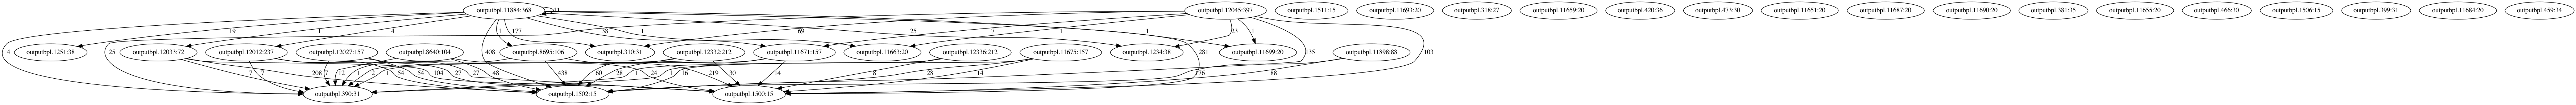

In [48]:
// Draw dependencies between user QIs (click to enlarge)
petgraph_evcxr::draw_graph(&deps)

In [49]:
// Adding conflicts (with multiplicities as weights)
for c in model.conflicts() {
    let n = deps.add_node(format!("conflict@{}", c.timestamp));
    let mut outgoing = HashMultiSet::new();
    for d in &c.qi_deps {
        if let Some(m) = model.key2name(&d.key) {
            outgoing.insert(m)
        }
    }
    for m in outgoing.distinct_elements() {
        let c = outgoing.count_of(m);
        if let Some(m) = pg_nodes.get(m) {
            deps.add_edge(n, *m, c.to_string());
        }
    }
}

()

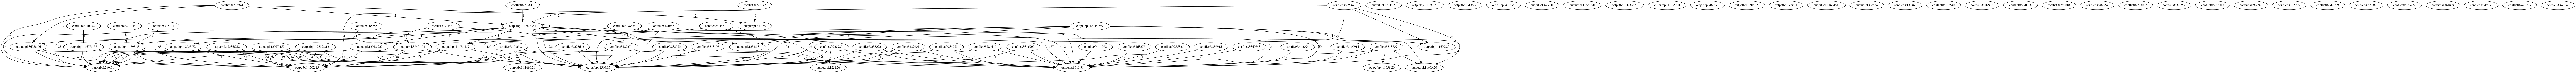

In [50]:
// Same drawing but including conflicts and their dependencies (click to enlarge)
petgraph_evcxr::draw_graph(&deps)